In [1]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
objPoints = pickle.load(open( "objPoints", "rb" ))
imgPoints = pickle.load(open("imgPoints","rb"))

In [3]:
def abs_sobel_thresh(img,orient='x',sobel_kernel=3,thresh=(0,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled>thresh[0]) & (scaled<thresh[1])]=1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,sobel_kernel)
    mag = np.sqrt((sobelx)*(sobelx)+(sobely)*(sobely))
    scaled = np.uint(255*mag/np.max(mag))
    binary_output=np.zeros_like(scaled)
    binary_output[(scaled>mag_thresh[0]) & (scaled<mag_thresh[1])]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    graddir = np.arctan2(abs_sobely,abs_sobelx)
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir>thresh[0]) & (graddir<thresh[1])]=1
    return binary_output

def color_threshold(img,thresh=(0,255)):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    channel = hls[:,:,2]
    binary = np.zeros_like(channel)
    binary[(channel>=thresh[0]) & (channel<=thresh[1])] =1
    return binary


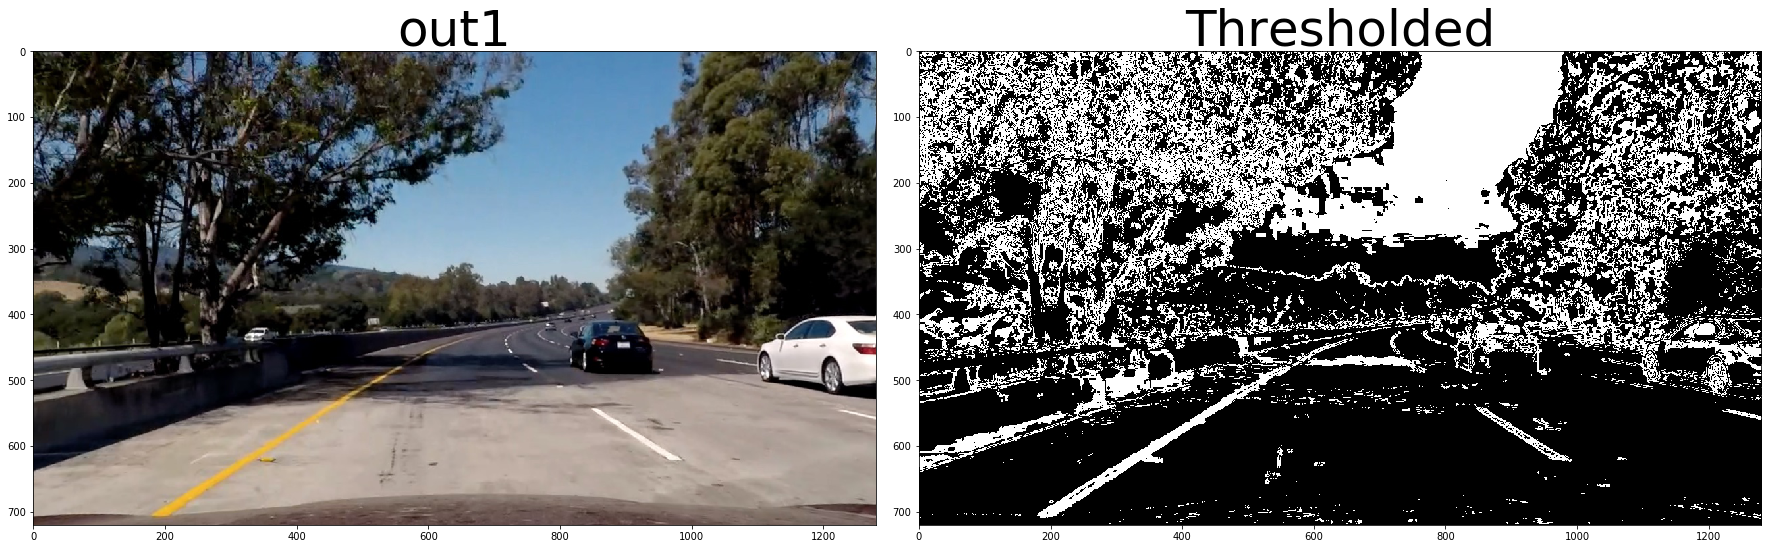

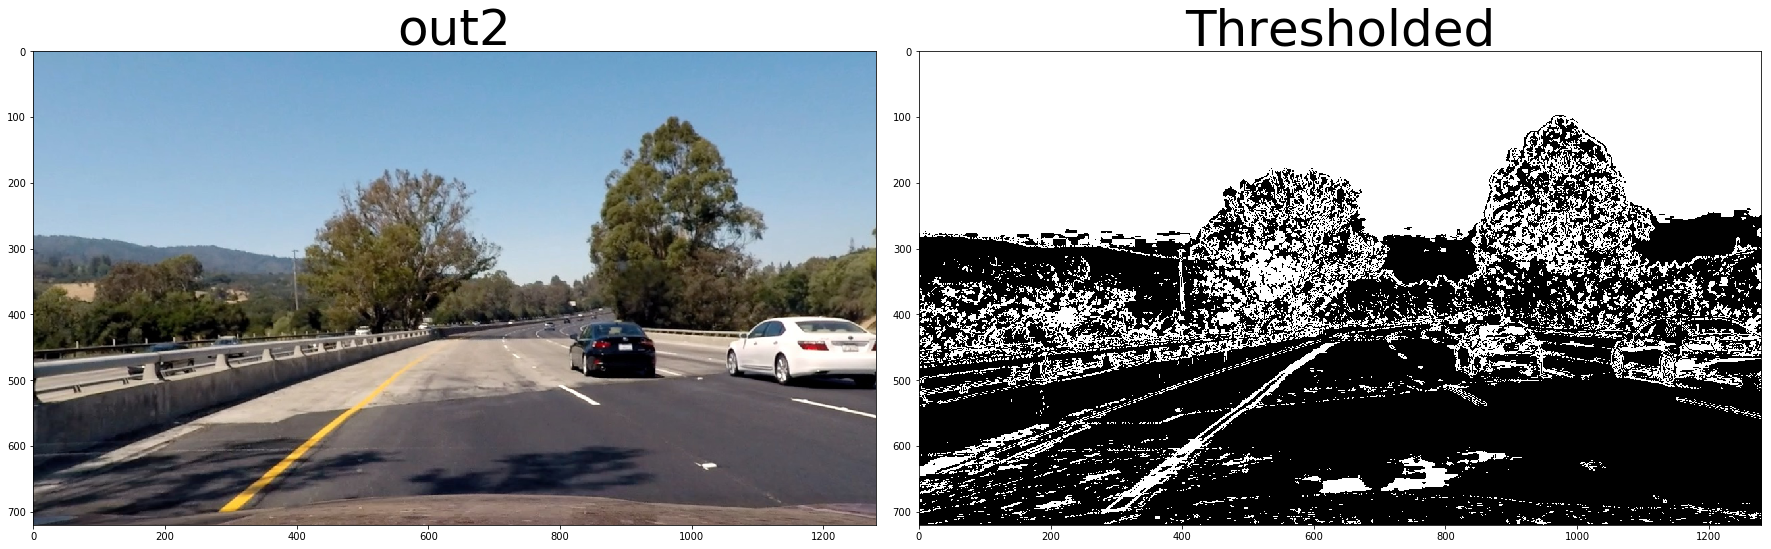

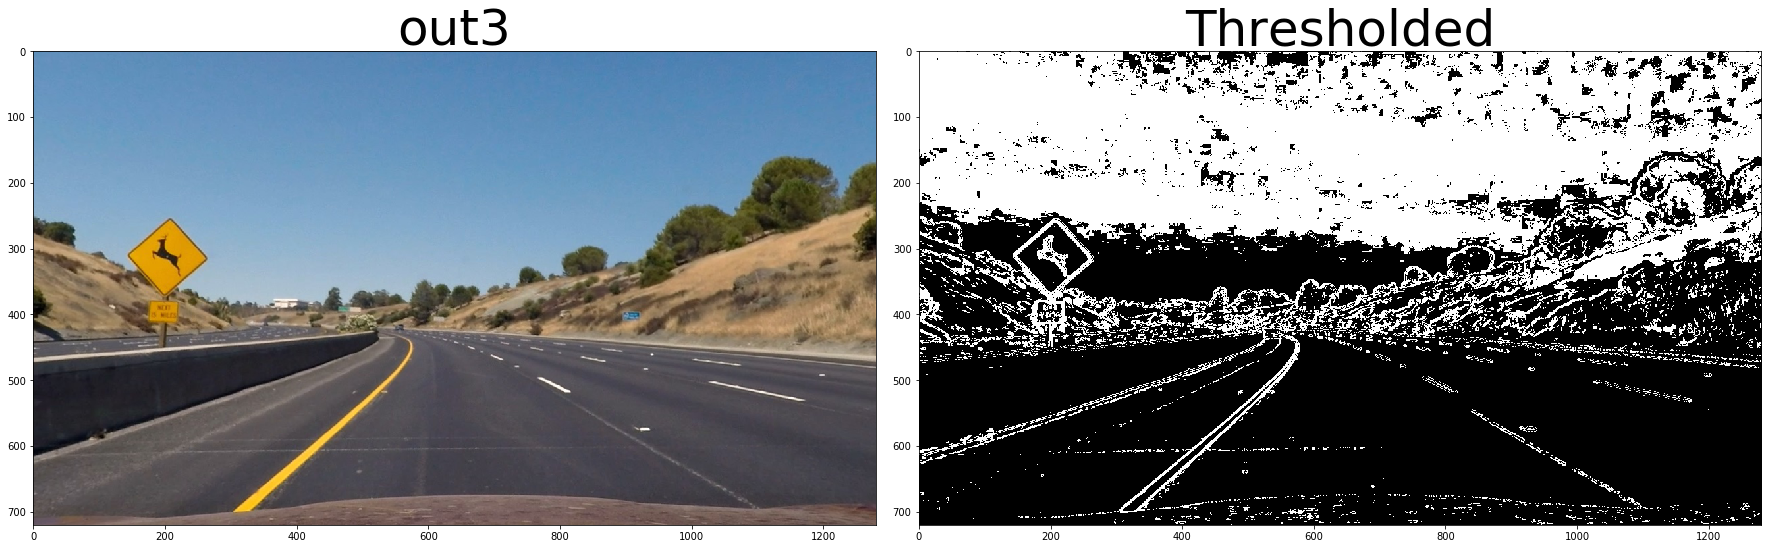

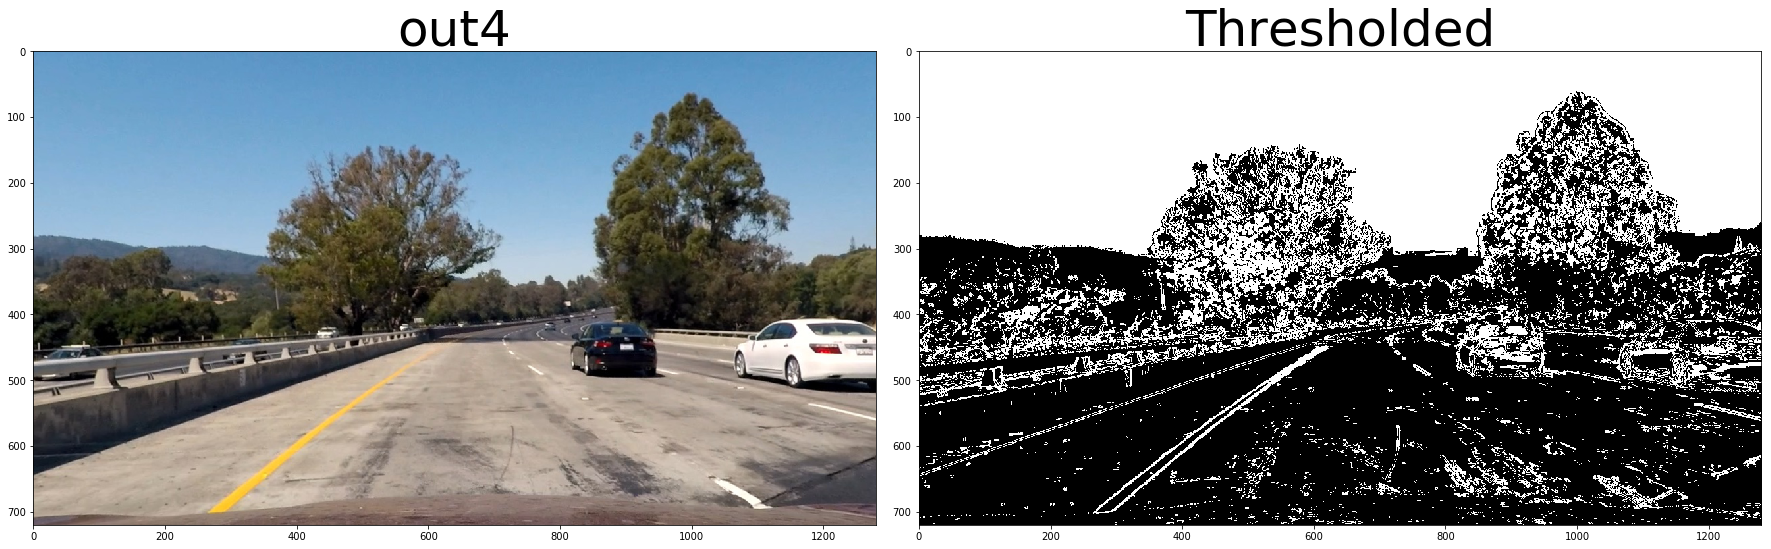

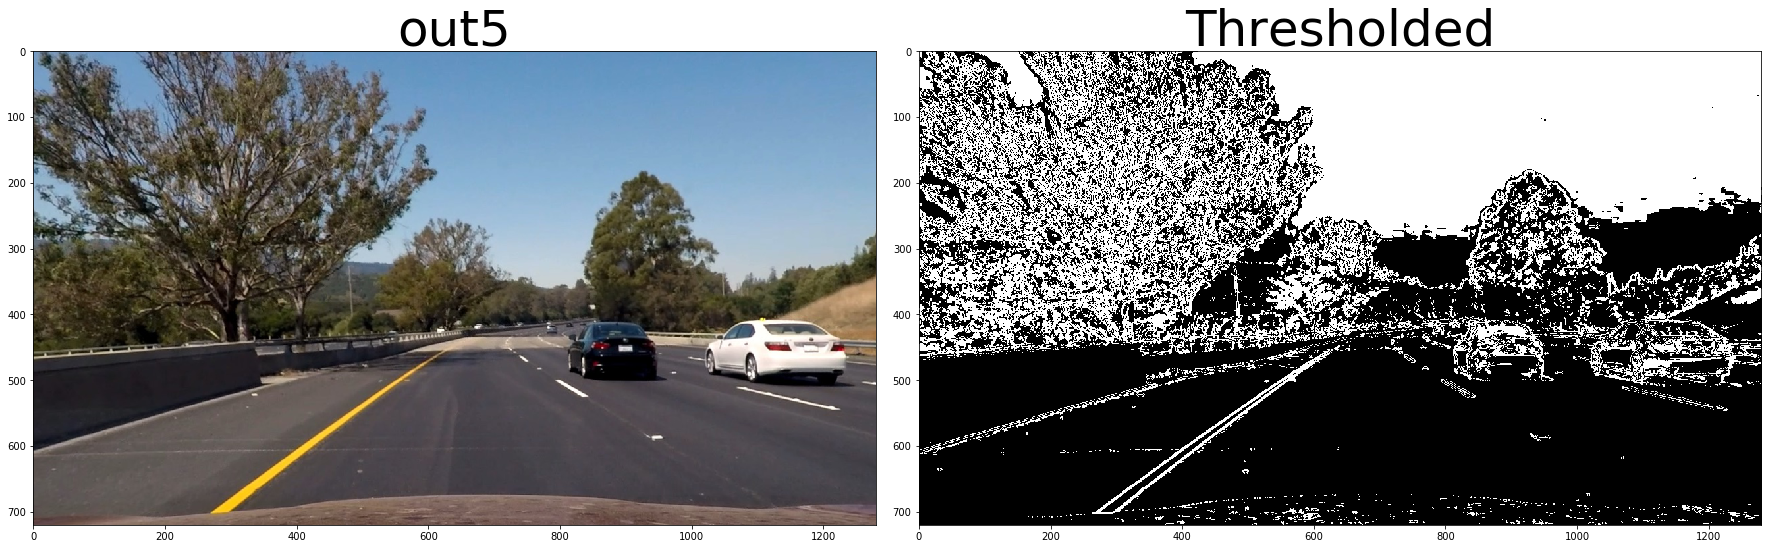

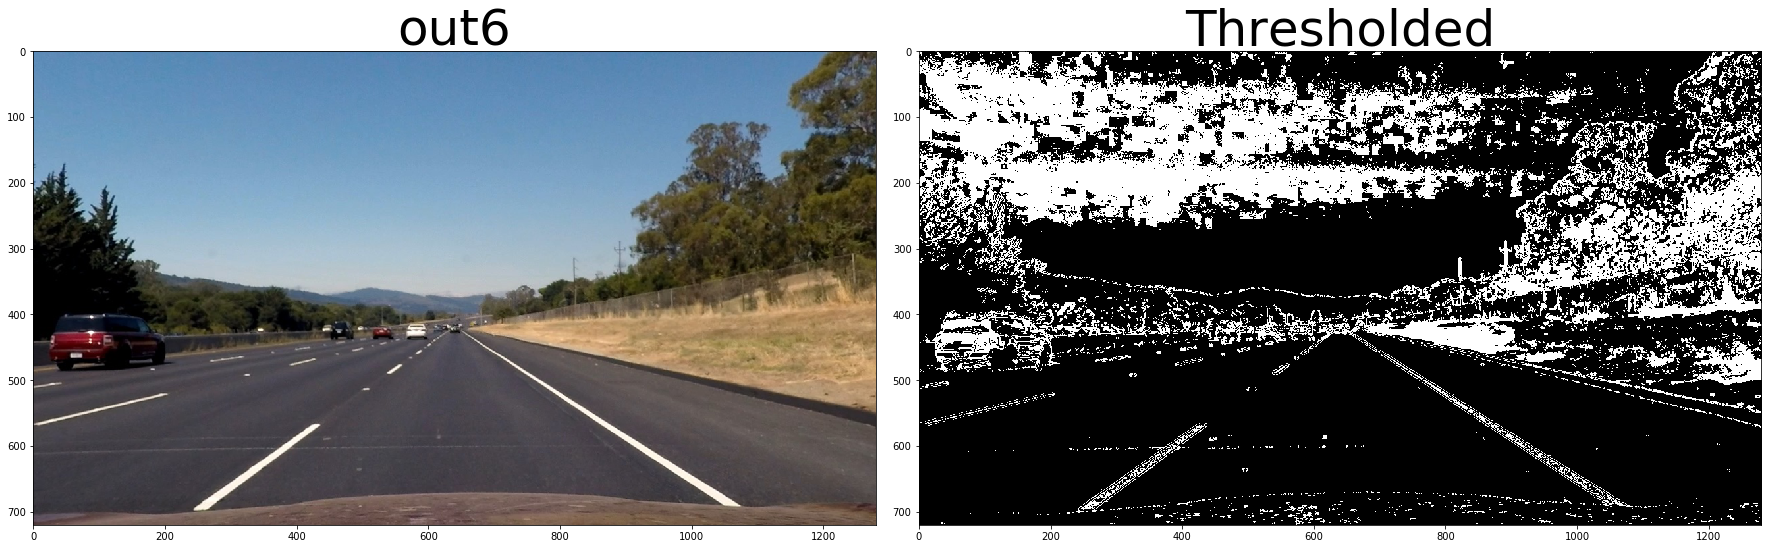

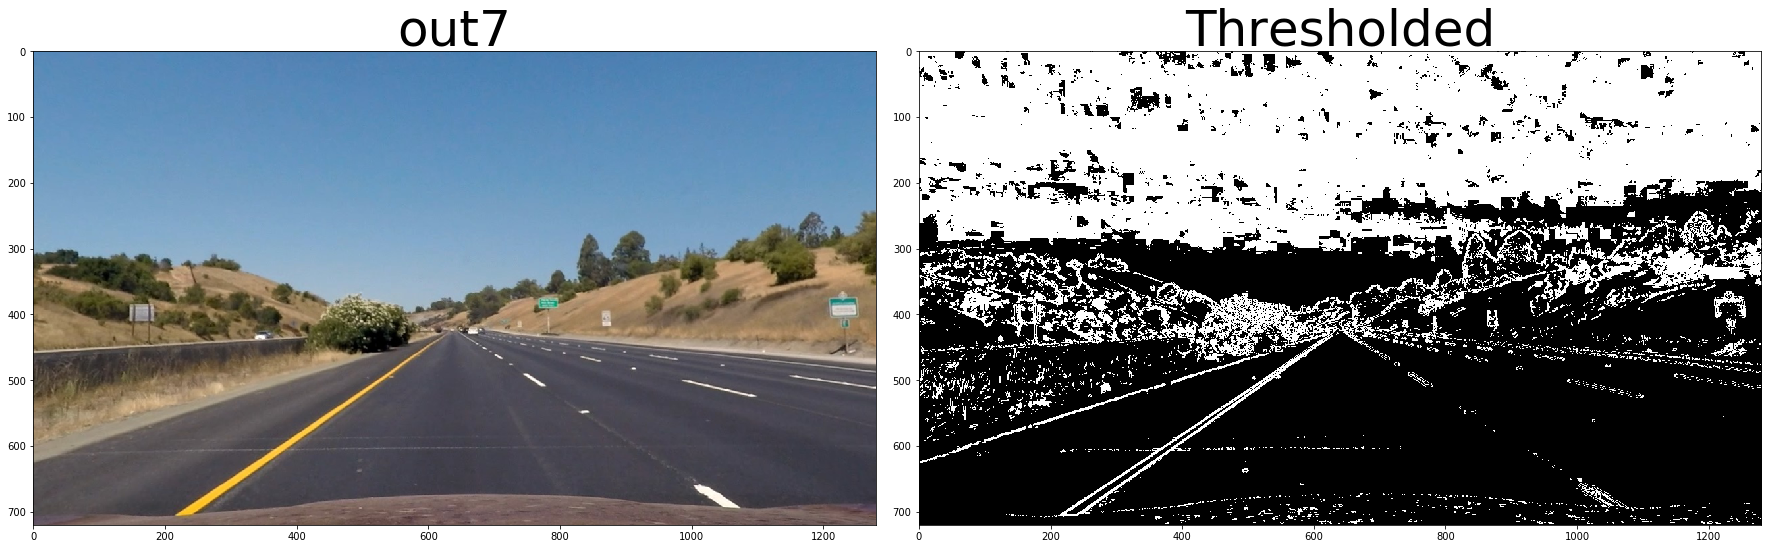

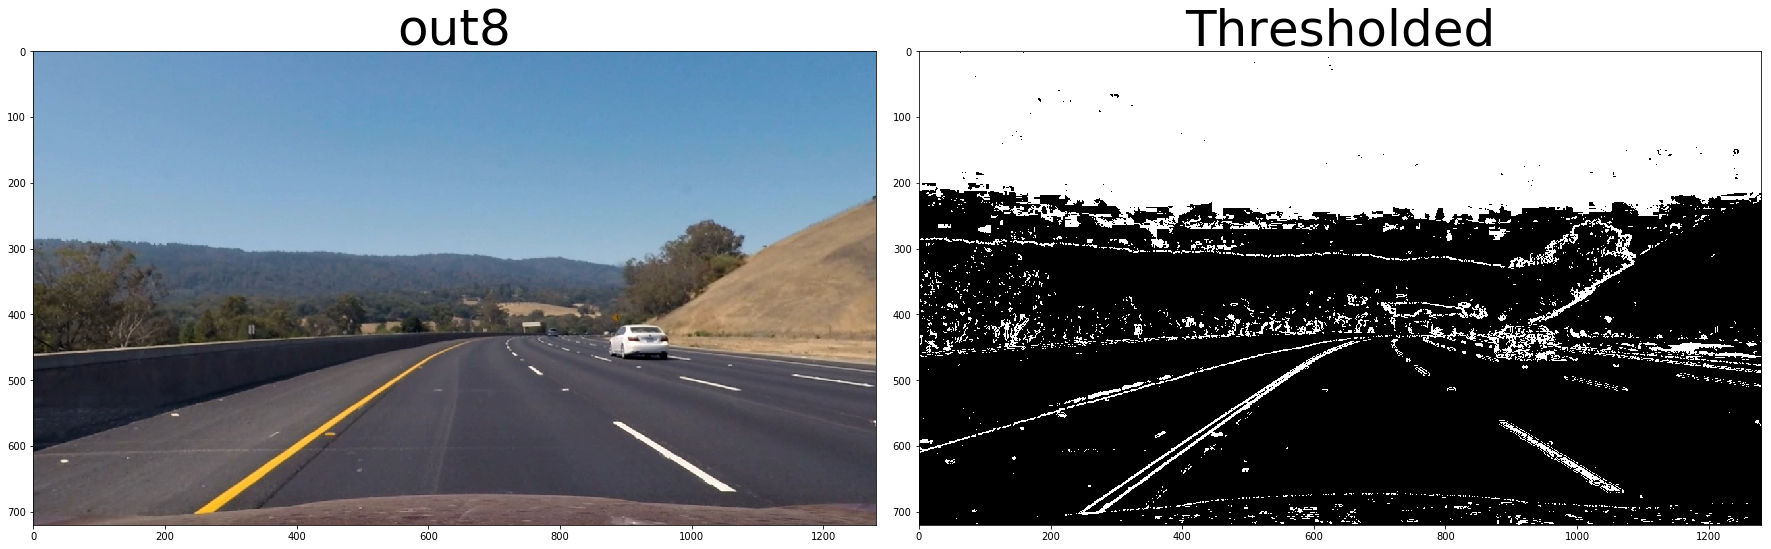

In [31]:
count=1
for img_name in glob.glob("./test_images/*.jpg"):
    test_img = mpimg.imread(img_name)
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objPoints,imgPoints,test_img.shape[1::-1],None,None)
    undist = cv2.undistort(test_img,mtx,dist,None,mtx)
    ksize = 5
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(5, 100))
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(undist, sobel_kernel=9, mag_thresh=(20, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=21, thresh=(-1.3,1.3))
    color_th = color_threshold(undist,(100,230))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary==1)) | (color_th == 1)] = 1
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist)
    ax1.set_title("out"+str(count), fontsize=50)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Thresholded', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    cv2.imwrite("test_images_output/"+"out"+str(count)+".jpg",combined*255)
    count+=1